Forked by Brigham Andersen

# Obtaining the data

The first portion of this notebook makes a connection to Kaggle for the purpose of downloading the [arXiv dataset](https://www.kaggle.com/Cornell-University/arxiv).  

In order to run it, you will need to have an API key for Kaggle, which we will use to set up the Kaggle CLI in this notebook.  Instructions for how to do this can be found in [this Medium post](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a).

The zipped archive of the dataset is approximately 960 MB and unzipped is approximately 2.6 GB.  You can upload it yourself to Google rather than making the connection via the Kaggle CLI as shown below, but this CLI method is significantly faster.

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files

## Note
In this next row, you will upload your kaggle.json file associated with your API key to Google, which is used in the following steps.

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brandonvinhle","key":"eaf5dd886512562f1268ed64ed6c4834"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           3253         98  1.0              
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25          19686        552  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           2323         61  1.0              
fuarresvij/gdp-growth-around-the-globe                      

In [6]:
!kaggle datasets download -d Cornell-University/arxiv

 99% 1.09G/1.10G [00:10<00:00, 115MB/s] 
100% 1.10G/1.10G [00:10<00:00, 114MB/s]


In [7]:
!unzip \*.zip && rm *.zip

Archive:  arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


# Prepare the remainder of the Python environment

Note that `tqdm` is optional, but I like to use it so I can tell where we are in the overall population of the dataframe, knowing that the file is approximately 1.79M rows long.

In [8]:
!pip install neo4j
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 174 kB 46.3 MB/s 
  Created wheel for neo4j: filename=neo4j-5.2.1-py3-none-any.whl size=249499 sha256=17f9b2fd0b518723fbe6cc80764ab3e379d9cf3b99042e60951b242aa8b8e846
  Stored in directory: /root/.cache/pip/wheels/b3/8c/94/ad2ec76fee32d266ed8954ba221bc716e468f24d1f07d98f92
Successfully built neo4j
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
%matplotlib inline

import json
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from neo4j import GraphDatabase

# Create some helper classes and functions

In [10]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [11]:
def get_author_list(line):
    # Cleans author dataframe column, creating a list of authors in the row.
    
    return [e[1] + ' ' + e[0] for e in line]


def get_category_list(line):
    # Cleans category dataframe column, creating a list of categories in the
    # row.
    
    return list(line.split(" "))


def add_categories(categories):
    # Adds category nodes to the Neo4j graph.
  
    query = '''UNWIND $rows AS row
    MERGE (c:Category {category: row.category})
    RETURN count(*) as total
    '''
    
    return conn.query(query, parameters={'rows': categories.to_dict('records')})


def add_authors(rows, batch_size=10000):
    # Adds author nodes to the Neo4j graph as a batch job.

    query = '''UNWIND $rows AS row
               MERGE (:Author {name: row.author})
               RETURN count(*) as total
    '''
    return insert_data(query, rows, batch_size)


def add_papers(rows, batch_size=5000):
    # Adds paper nodes and (:Author)--(:Paper) and (:Paper)--(:Category)
    # relationships to the Neo4j graph as a batch job.  (Note the smaller batch
    # size due to the fact that this function is adding much more data than the
    # add_authors() function.)

    query = '''
    UNWIND $rows as row
    MERGE (p:Paper {id:row.id}) ON CREATE SET p.title = row.title

    // connect categories
    WITH row, p
    UNWIND row.category_list AS category_name
    MATCH (c:Category {category: category_name})
    MERGE (p)-[:IN_CATEGORY]->(c)

    // connect authors
    WITH distinct row, p // reduce cardinality
    UNWIND row.cleaned_authors_list AS author
    MATCH (a:Author {name: author})
    MERGE (a)-[:AUTHORED]->(p)
    RETURN count(distinct p) as total
    '''

    return insert_data(query, rows, batch_size)


def insert_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.

    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query, parameters={'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total, "batches":batch, "time":time.time()-start}
        print(result)

    return result


# Data loading and cleaning

In [12]:
file = "./arxiv-metadata-oai-snapshot.json"

metadata  = []

lines = 1000000    # 100k for testing
with open(file, 'r') as f:
    for line in tqdm(f): 
        metadata.append(json.loads(line))
        lines -= 1
        if lines == 0: break

df = pd.DataFrame(metadata)
df.head()

999999it [00:52, 18969.25it/s]


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [13]:
df['cleaned_authors_list'] = df['authors_parsed'].map(get_author_list)
df['category_list'] = df['categories'].map(get_category_list)
df = df.drop(['submitter', 'authors', 'comments', 'journal-ref', 'doi', 
              'report-no', 'license', 'versions', 'update_date', 'abstract', 
              'authors_parsed', 'categories'], axis=1)
df.head()

,id,title,cleaned_authors_list,category_list
0,0704.0001,Calculation of prompt diphoton production cros...,"[C. Balázs, E. L. Berger, P. M. Nadolsky, C. -...",[hep-ph]
1,0704.0002,Sparsity-certifying Graph Decompositions,"[Ileana Streinu, Louis Theran]","[math.CO, cs.CG]"
2,0704.0003,The evolution of the Earth-Moon system based o...,[Hongjun Pan],[physics.gen-ph]
3,0704.0004,A determinant of Stirling cycle numbers counts...,[David Callan],[math.CO]
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,"[Wael Abu-Shammala, Alberto Torchinsky]","[math.CA, math.FA]"


# Prepare :Category nodes

In [14]:
categories = pd.DataFrame(df[['category_list']])
categories.rename(columns={'category_list':'category'}, inplace=True)
categories = categories.explode('category').drop_duplicates(subset=['category'])

categories.size

156

# Prepare :Author nodes

In [15]:
authors = pd.DataFrame(df[['cleaned_authors_list']])

authors.rename(columns={'cleaned_authors_list':'author'}, inplace=True)
authors=authors.explode('author').drop_duplicates(subset=['author'])

authors.size

774339

# Establish connection to Neo4j Sandbox instance

This demonstrationg uses the [Neo4j Sandbox](sandbox.neo4j.com), but a connection to any running Neo4j database will work, including your local machine.  A Sandbox instance does not last longer than about 3 days, so you will need to populate these values with that of your own instance.

In [16]:
conn = Neo4jConnection(uri="bolt://44.202.216.69:7687", user="neo4j", pwd="mixture-case-alternate")

# Populate the database

This is achieved in three steps.  First, we create all constraints guaranteeing the uniqueness of each node.  Second, we create the each of the nodes themselves.  Finally, we create the relationships between all nodes (`:AUTHORED` and `:IN_CATEGORY`).  

In [17]:
conn.query('CREATE CONSTRAINT papers IF NOT EXISTS ON (p:Paper) ASSERT p.id IS UNIQUE')
conn.query('CREATE CONSTRAINT authors IF NOT EXISTS ON (a:Author) ASSERT a.name IS UNIQUE')
conn.query('CREATE CONSTRAINT categories IF NOT EXISTS ON (c:Category) ASSERT c.category IS UNIQUE')

[]

In [18]:
add_categories(categories)

[<Record total=156>]

In [19]:
add_authors(authors)

{'total': 10000, 'batches': 1, 'time': 31.79363441467285}
{'total': 20000, 'batches': 2, 'time': 41.08006834983826}
{'total': 30000, 'batches': 3, 'time': 44.375404357910156}
{'total': 40000, 'batches': 4, 'time': 48.18710470199585}
{'total': 50000, 'batches': 5, 'time': 49.77968621253967}
{'total': 60000, 'batches': 6, 'time': 50.59222388267517}
{'total': 70000, 'batches': 7, 'time': 51.58122444152832}
{'total': 80000, 'batches': 8, 'time': 52.37989091873169}
{'total': 90000, 'batches': 9, 'time': 53.40378975868225}
{'total': 100000, 'batches': 10, 'time': 54.495272159576416}
{'total': 110000, 'batches': 11, 'time': 55.272820472717285}
{'total': 120000, 'batches': 12, 'time': 56.79674410820007}
{'total': 130000, 'batches': 13, 'time': 58.57795739173889}
{'total': 140000, 'batches': 14, 'time': 59.37500762939453}
{'total': 150000, 'batches': 15, 'time': 60.20215344429016}
{'total': 160000, 'batches': 16, 'time': 61.01967263221741}
{'total': 170000, 'batches': 17, 'time': 61.78874778747

{'total': 774339, 'batches': 78, 'time': 124.97585439682007}

# Add :Papers nodes and population all relationships

(This might take a few minutes.)

In [20]:
add_papers(df)

{'total': 5000, 'batches': 1, 'time': 31.778187036514282}
{'total': 10000, 'batches': 2, 'time': 44.89191436767578}
{'total': 15000, 'batches': 3, 'time': 55.394097566604614}
{'total': 20000, 'batches': 4, 'time': 58.877612829208374}
{'total': 25000, 'batches': 5, 'time': 62.50079345703125}
{'total': 30000, 'batches': 6, 'time': 66.61822938919067}
{'total': 35000, 'batches': 7, 'time': 70.22072386741638}
{'total': 40000, 'batches': 8, 'time': 75.70439004898071}
{'total': 45000, 'batches': 9, 'time': 81.07893562316895}
{'total': 50000, 'batches': 10, 'time': 84.97992253303528}
{'total': 55000, 'batches': 11, 'time': 88.69503927230835}
{'total': 60000, 'batches': 12, 'time': 91.81410932540894}
{'total': 65000, 'batches': 13, 'time': 99.3781144618988}
{'total': 70000, 'batches': 14, 'time': 105.00033760070801}
{'total': 75000, 'batches': 15, 'time': 108.58268976211548}
{'total': 80000, 'batches': 16, 'time': 111.78367686271667}
{'total': 85000, 'batches': 17, 'time': 115.1863305568695}
{'

{'total': 1000000, 'batches': 200, 'time': 1302.8970968723297}

# Confirm the database is properly populated with some simple queries

In [25]:
# Default Code
# query_string = '''
# MATCH (c:Category) 
# RETURN c.category, SIZE(()-[:IN_CATEGORY]->(c)) AS inDegree 
# ORDER BY inDegree DESC LIMIT 20
# '''

query_string = '''
MATCH (c:Category) 
WHERE c.category STARTS WITH 'cs'
RETURN SUM(SIZE(()-[:IN_CATEGORY]->(c))) AS numCsPapers 
'''

# 223389

top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
top_cat_df.head(20)

,numCsPapers
0,223389


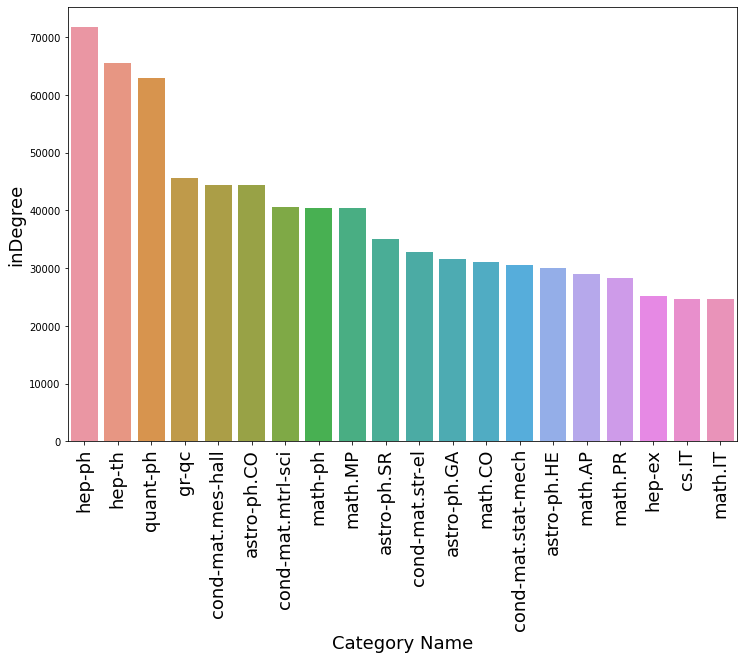

In [22]:
plt.figure(figsize=(12,8))
sns.barplot(x=top_cat_df['c.category'], y=top_cat_df['inDegree'])
plt.xlabel('Category Name', fontsize=18)
plt.ylabel('inDegree',fontsize=18)
plt.xticks(rotation='vertical', fontsize=18)
plt.show()

# Alternative method to read graph data from Neo4j back to Python

In [23]:
result = conn.query(query_string)

for record in result:
    print(record[0], record[1])

hep-ph 71727
hep-th 65598
quant-ph 62955
gr-qc 45613
cond-mat.mes-hall 44464
astro-ph.CO 44417
cond-mat.mtrl-sci 40541
math-ph 40414
math.MP 40414
astro-ph.SR 35122
cond-mat.str-el 32788
astro-ph.GA 31565
math.CO 31054
cond-mat.stat-mech 30628
astro-ph.HE 30021
math.AP 29021
math.PR 28253
hep-ex 25180
cs.IT 24669
math.IT 24669
